# Aarav Nigam
# Trading Model (RL Model)

## Importing Libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from collections import deque
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


## Defining Variables



In [2]:
path='./DATA/data.csv'

# Define hyperparameters

hidden_size1 = 256
hidden_size2 = 64

output_size = 3
learning_rate = 0.0005
gamma = 0.95
epsilon_start = 0.95
epsilon_end = 0.01
epsilon_decay = 0.99
episodes = 8
batch_size = 64
window_size = 10  # Number of days to consider as a window
input_size = 18*window_size  # Features per day are
update_freq = 20
update_cnt = 0
update_upperBound = 500
tax_charge = 0.001

In [3]:
np.random.seed(28)
torch.manual_seed(28)

In [4]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Importing Data

In [5]:
# Load the CSV file into a DataFrame
df = pd.read_csv(path)
df.head()

,datetime,open,high,low,close,volume,reserve,funding_rates,mvrv,nrpl,nupl,stock_to_flow_reversion,sth_sopr,signal,RSI,9_ema,21_ema,50_ema,200_ema,Fear_and_Greed_Index
0,2020-07-16,9190.80,9216.02,9005.00,9130.11,8765.698589,2.889262e+06,0.009332,1.563972,-3.694023e+06,0.360602,0.421011,0.997131,none,47.108800,9214.535081,9196.119258,9524.945856,9671.528810,43
1,2020-07-17,9130.93,9182.99,9054.99,9154.29,6423.747162,2.889943e+06,0.007262,1.568555,3.367513e+05,0.362471,0.366354,0.999726,none,48.843088,9202.486065,9206.292278,9560.413230,9718.271795,41
2,2020-07-18,9154.29,9210.00,9122.65,9175.85,4121.626974,2.890642e+06,0.004125,1.572507,7.637219e+06,0.364073,0.404649,1.000724,buy,50.404638,9197.158852,9216.465298,9595.880603,9765.014781,44
3,2020-07-19,9175.83,9245.03,9105.37,9212.87,3520.072476,2.892067e+06,0.007809,1.579355,2.053120e+07,0.366830,0.409607,1.000859,none,53.054470,9200.301081,9226.638318,9631.347977,9811.757766,41
4,2020-07-20,9214.01,9223.51,9131.00,9161.05,5815.330842,2.891858e+06,0.010244,1.568483,7.103351e+06,0.362441,0.437860,1.000647,none,49.099864,9192.450865,9236.811338,9666.815351,9858.500751,44


## Creating RL Model

In [6]:
# Define the environment and reward function
def get_reward(action,close,open):
    rew = (action-1)*(close-open)/open
    if(rew>0): rew-=tax_charge
    return rew

In [7]:

# Define the Deep Q-Network (DQN) model
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size2//2)
        self.fc4 = nn.Linear(hidden_size2//2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the Deep Q-Learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_size1, hidden_size2, learning_rate, gamma, epsilon_start, epsilon_end, epsilon_decay):
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.model = DQN(state_size, hidden_size1, hidden_size2, action_size).to(device)
        self.target_model = DQN(state_size, hidden_size1, hidden_size2, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.memory = deque(maxlen=10000)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state.flatten()).unsqueeze(0).to(device)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            state = torch.FloatTensor(state.flatten()).unsqueeze(0).to(device)
            next_state = torch.FloatTensor(next_state.flatten()).unsqueeze(0).to(device)
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.target_model(next_state).detach())
            target_f = self.model(state).squeeze(0)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state).squeeze(0), target_f)
            loss.backward()
            self.optimizer.step()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

In [8]:
# Define the environment class
class StockMarketEnvironment:
    def __init__(self, data, window_size):

        # Removing Date and Time because the data is already continuous format
        X = data.drop(['datetime','signal'], axis=1)

        self.data = X
        self.window_size = window_size
        self.current_step = window_size
        self.scaler = StandardScaler()
        self.data_normalized = self.scaler.fit_transform(X.values)
        self.data_length = len(X)

    def reset(self):
        self.current_step = self.window_size
        return self.data_normalized[0:self.window_size]

    def step(self, action):
        reward = get_reward(action, self.data_normalized[self.current_step][3], self.data_normalized[self.current_step][0])
        next_step = self.current_step + 1
        done = next_step >= self.data_length
        next_state = self.data_normalized[next_step - self.window_size:next_step]
        self.current_step = next_step
        return next_state, reward, done, {}


In [9]:
# Training the DQN agent
def train_dqn_agent(env, agent, episodes, batch_size):
    global update_cnt, update_freq
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.replay(batch_size)
            if (update_freq <= update_upperBound and update_cnt == update_freq):
                agent.update_target_model()
                update_cnt = 0
                update_freq += 50
            update_cnt += 1
            agent.decay_epsilon()
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")


In [10]:
# Initializing the Environment
env = StockMarketEnvironment(df, window_size)

In [11]:

# Initialize the DQN agent
agent = DQNAgent(input_size, output_size, hidden_size1,hidden_size2, learning_rate, gamma, epsilon_start, epsilon_end, epsilon_decay)


/home/aaravnigam/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:

# Train the DQN agent
train_dqn_agent(env, agent, episodes, batch_size)

Episode: 1, Total Reward: 8.804514490980289
Episode: 2, Total Reward: 103.47283430039988
Episode: 3, Total Reward: 115.27070400199
Episode: 4, Total Reward: 128.17450527202735
Episode: 5, Total Reward: 135.69712730124618
Episode: 6, Total Reward: 133.2906400504113
Episode: 7, Total Reward: 144.7352931855256
Episode: 8, Total Reward: 135.15019939297838


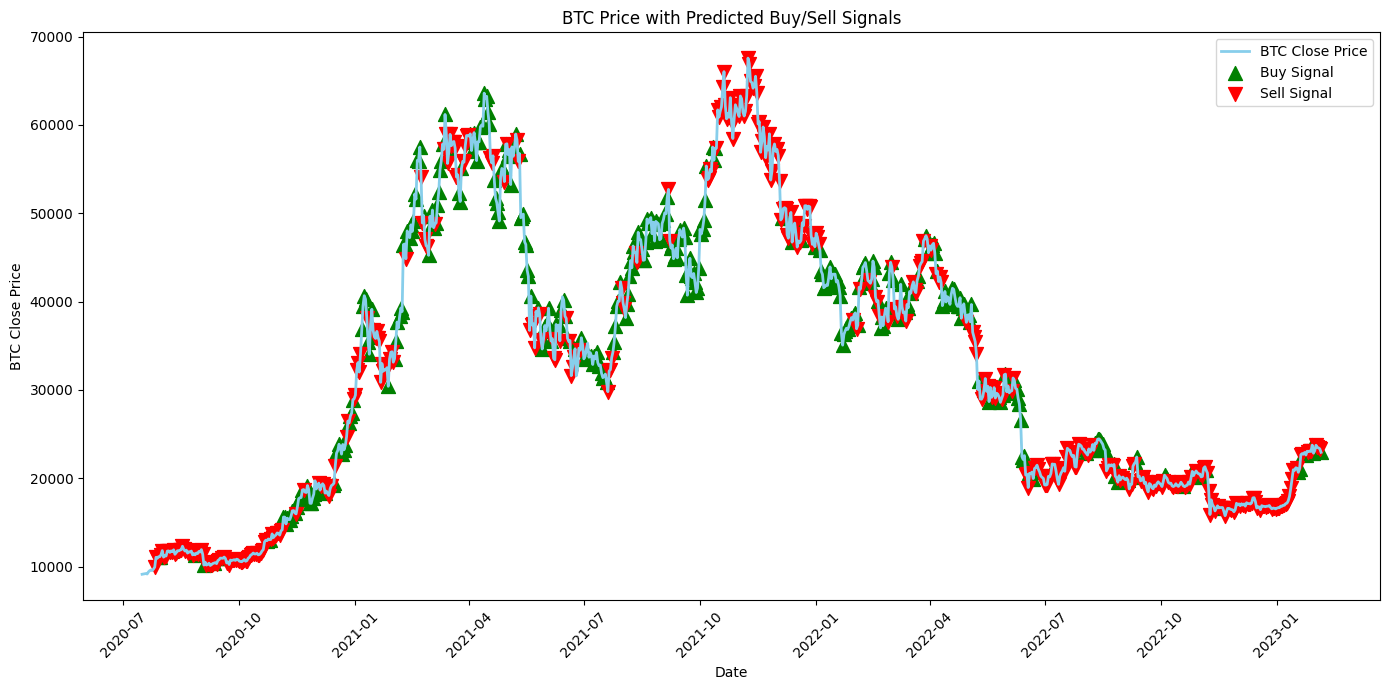

In [15]:
df = pd.read_csv(path)

env = StockMarketEnvironment(df, window_size)

# Function to apply prediction to each row
def predict_signal_for_row(df, index):
    if(index<window_size):
        return 1;
    last_window_rows = data_normalized[index - window_size:index]
    return agent.act(last_window_rows)


data_normalized=env.data_normalized


df['predicted_signal']=[predict_signal_for_row(data_normalized, i) for i in range(len(data_normalized))]

# Ensure datetime is in the correct format
datetime = pd.to_datetime(df['datetime'])



plt.figure(figsize=(14, 7))
plt.plot(datetime, df['close'], label='BTC Close Price', color='skyblue', linewidth=2)

df = df.drop(['datetime','signal'], axis=1)






df['datetime']=datetime
# Adjust the conditions to match the labels
# Highlight buy signals
buy_signals = df[df['predicted_signal'] == 2]  # Assuming 0 represents 'buy'
plt.scatter(buy_signals['datetime'], buy_signals['close'], label='Buy Signal', marker='^', color='green', alpha=1, s=100)

# Highlight sell signals
sell_signals = df[df['predicted_signal'] == 0]  # Assuming 1 represents 'sell'
plt.scatter(sell_signals['datetime'], sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1, s=100)

plt.title('BTC Price with Predicted Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("")
plt.show()
